<a href="https://colab.research.google.com/github/mishok2503/3D-Dempster-Shafer-SLAM/blob/main/bag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import yaml
import math
import json
import struct
from scipy.spatial.transform import Rotation

# Get data

Find .bag file with 2d or 3d lidar data.

Examples:
#### 2D
* https://drive.google.com/drive/folders/1cbhDEAzEc_yv__v5Ahkt1q7O3QePbuMr
    * 2011-01-24-06-18-27.bag
    * 2011-01-25-06-29-26.bag
* https://storage.googleapis.com/cartographer-public-data/bags/backpack_2d/cartographer_paper_deutsches_museum.bag

#### 3D
* https://storage.googleapis.com/cartographer-public-data/bags/backpack_3d/with_intensities/b3-2016-04-05-14-14-00.bag
* https://drive.google.com/drive/folders/1R-XhMnw-ndGzqsQGJQeol4tTnfK4PK9r
    * fast1.bag

## Extract lidar data

Download the file to the machine where ROS is installed.

Then run `rosbag info <your-file>` you will get something like this:
```
path:         cartographer_paper_deutsches_museum.bag
version:      2.0
duration:     31:52s (1912s)
start:        May 26 2015 13:30:16.48 (1432647016.48)
end:          May 26 2015 14:02:09.46 (1432648929.46)
size:         470.5 MB
messages:     617965
compression:  bz2 [3334/3334 chunks; 18.31%]
uncompressed:   2.5 GB @   1.3 MB/s
compressed:   462.3 MB @ 247.5 KB/s (18.31%)
types:        sensor_msgs/Imu                [6a62c6daae103f4ff57a132d6f95cec2]
              sensor_msgs/MultiEchoLaserScan [6fefb0c6da89d7c8abe4b339f5c2f8fb]
topics:       horizontal_laser_2d    70358 msgs    : sensor_msgs/MultiEchoLaserScan
              imu                   478244 msgs    : sensor_msgs/Imu               
              vertical_laser_2d      69363 msgs    : sensor_msgs/MultiEchoLaserScan
```

You need to find a topic with lidar data, messages must be of type `sensor_msgs/LaserScan` or `sensor_msgs/MultiEchoLaserScan` for 2D and `sensor_msgs/PointCloud2` for 3D.

Then you need to extract this topic in a separate file, for this use:
```bash
rostopic echo -b <bag-file> [-n messages_count] /topic_name > <topic-file>
```
`<topic-file>` will contain data from the topic in the form of yaml.



# Converting to json

In [2]:
def get_time(msg):
    stamp = msg["header"]["stamp"]
    return stamp["secs"], stamp["nsecs"]

The results of both 2d and 3d can be checked using [this](https://github.com/mishok2503/slam-3d-datasets-generator#test-the-result).

## 2D

In [3]:
# https://docs.ros.org/en/api/sensor_msgs/html/msg/LaserScan.html
# https://docs.ros.org/en/melodic/api/sensor_msgs/html/msg/MultiEchoLaserScan.html

def bag2json2d(get_range, input_filename, output_name):
    res, stamps = [], []
    with open(input_filename, "r") as topic:
        for msg in yaml.load_all(topic, Loader=yaml.CLoader):
            if not msg:
                continue

            lidar_data = []
            r_min = float(msg["range_min"])
            r_max = float(msg["range_max"])
            a = float(msg["angle_min"])
            da = float(msg["angle_increment"])
            for r in map(get_range, msg["ranges"]):
                coordinates = [r * math.cos(a), r * math.sin(a), 0]
                point_type = "point"
                if r <= r_min:
                    point_type = "unknown"
                if r >= r_max:
                    point_type = "max"
                lidar_data.append({
                    "type": point_type,
                    "coordinates": coordinates,
                    "quality": 1
                })
                a += da

            stamps.append(get_time(msg))
            res.append({
                "lidar_data": lidar_data,
                # TODO: add odometry if it's possible
                "odometry": {
                    "position": [0, 0, 0],
                    "euler_angles": [0, 0, 0]
                }
            })

    # write times
    with open("stamps_" + output_name + ".txt", "w") as stamps_file:
        for line in stamps:
            print("{} {}".format(line[0], line[1]), file=stamps_file)

    # write scans
    with open(output_name + ".json", "w") as file:
        json.dump({"data": {"measurements": res}}, file)

In [4]:
def laser_scan(input_filename, output_name):
    bag2json2d(float, input_filename, output_name)

def multi_echo_laser_scan(input_filename, output_name):
    bag2json2d(lambda elem: float(elem["echoes"][0]), input_filename, output_name)

In [5]:
# examples
laser_scan("2011-01.yaml", "laser_scan") # result: laser_scan.json and times_laser_scan.txt
multi_echo_laser_scan("deutsches_museum.yaml", "multi_scan") # result: multi_scan.json and times_multi_scan.txt

## 3D

In some datasets, the full scan is divided into many small fragments. To make the scan more informative, each `scan_size` is combined into one.

In [6]:
# https://docs.ros.org/en/api/sensor_msgs/html/msg/PointCloud2.html

def bag2json3d(input_filename, output_name, scan_size=1):
    asd = 0
    res, stamps = [], []
    with open(input_filename, "r") as topic:
        lidar_data = []
        fragments_count = 0
        for msg in yaml.load_all(topic, Loader=yaml.CLoader):
            if not msg:
                continue

            data = msg["data"]
            point_step = int(msg["point_step"])
            for i in range(0, len(data), point_step):
                coordinates = [0, 0, 0]
                for field in msg["fields"]:
                    id = {"x": 0, "y" : 1, "z": 2}.get(field["name"])
                    if id is None:
                        continue
                    offset = field["offset"]
                    t = sum([data[i + j + offset] << j * 8 for j in range(4)])
                    f = struct.unpack('f', t.to_bytes(4, "little"))[0]
                    coordinates[id] = f

                lidar_data.append({
                    "coordinates": coordinates,
                    "type": "point",
                    "quality": 1
                })

            fragments_count += 1
            if fragments_count >= scan_size:
                fragments_count = 0
                stamps.append(get_time(msg))
                res.append({
                    "lidar_data": lidar_data,
                    "odometry": {
                        # TODO: add odometry if it's possible
                        "position": [0, 0, 0],
                        "euler_angles": [0, 0, 0]
                    }
                })
                lidar_data = []

    # write times
    with open("stamps_" + output_name + ".txt", "w") as stamps_file:
        for line in stamps:
            print("{} {}".format(line[0], line[1]), file=stamps_file)

    # write scans
    with open(output_name + ".json", "w") as file:
        json.dump({"data": {"measurements": res}}, file)

In [7]:
# exmples
bag2json3d("b3.yaml", "cartographer", 100)
bag2json3d("fast.yaml", "fast", 1)

## Stamps file

Since this slam algorithm works in steps, not in time, it loses information about when it was scanned. Therefore, to plot graphs with time, we need to save the timestamps of all scans.

# Draw results

In [46]:
def draw_position(*data, axis=[0, 1, 2]):
    for i, (x, y) in enumerate(data):
        label = np.array([c + str(i) for c in ["x", "y", "z"]])[axis]
        plt.plot(x, np.array(y)[:, axis], label=label if len(axis) != 1 else label[0])
    plt.legend(loc="lower left")
    plt.show()

def draw_orientation(*data, axis=[0, 1, 2]):
    draw_position(*[(x, y[:, 3:]) for x, y in data], axis=axis)

## Merge with stamps

In [47]:
def get_track(trajectory_file, stamps_file):
    x = []
    with open(stamps_file, "r") as stamps:
        for line in stamps:
            secs, nsecs = list(map(int, line.split()))
            x.append(secs + nsecs / 1e9)

    y = []
    with open(trajectory_file, "r") as trajectory:
        y = [list(map(float, line.split())) for line in trajectory]

    return x, np.array(y) - y[0]

In [48]:
track = get_track("robot_trajectory.txt", "stamps_cartographer.txt")

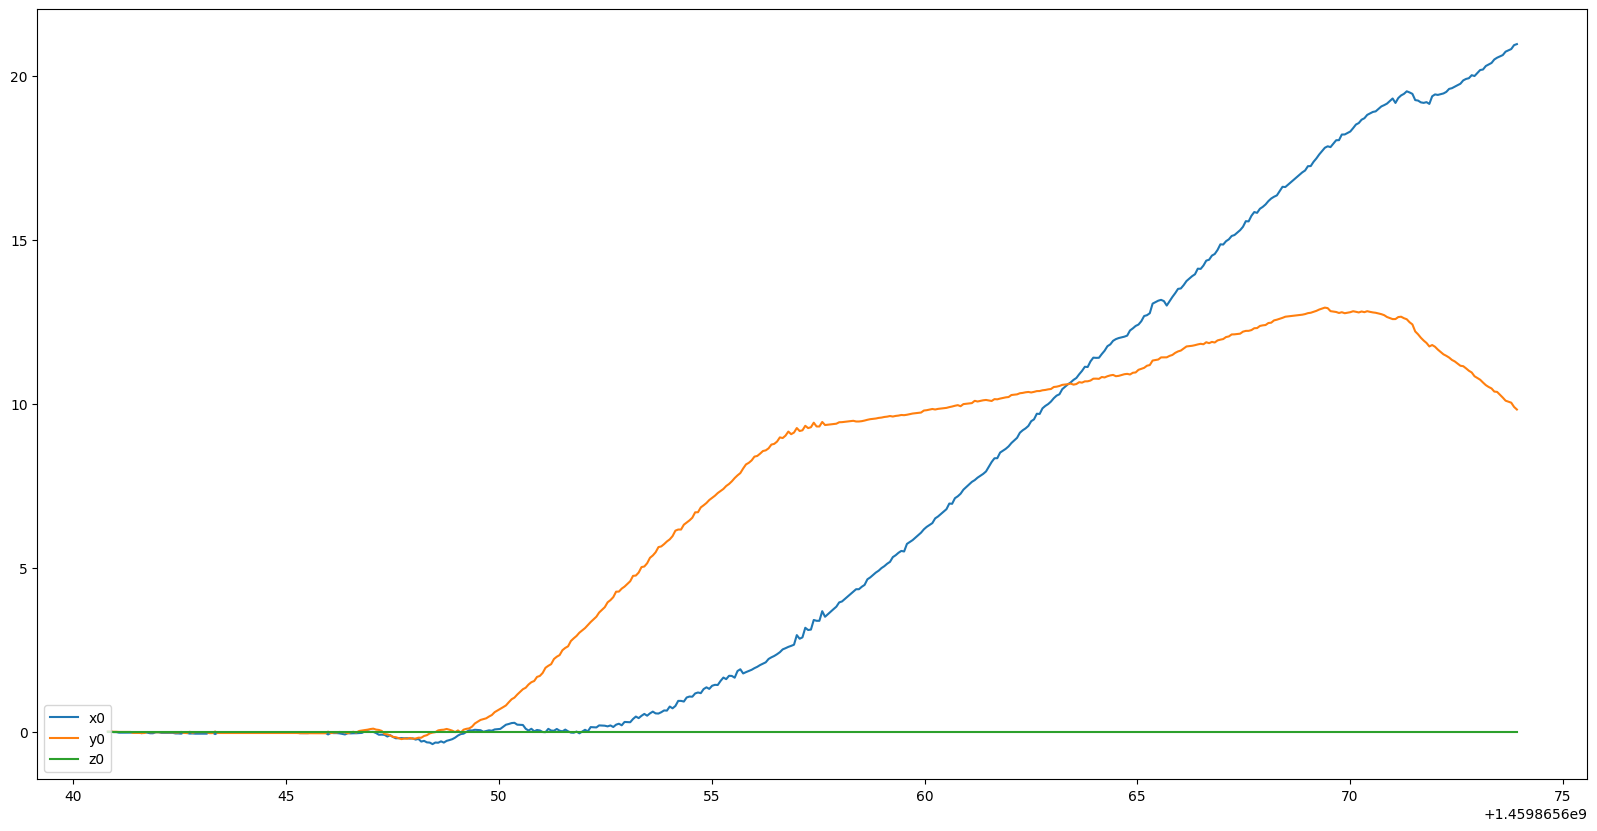

In [49]:
draw_position(track)

## Cartographer ground truth

In [8]:
plt.rcParams["figure.figsize"] = (20,10) # change pictures sizes

We can compare the results of this algorithm with the results of the cartographer, assuming that it is ground truth.

To do this, you need to install a cartographer, you can use [this instruction](https://google-cartographer-ros.readthedocs.io/en/latest/compilation.html).

Then you must to [turn on the topic that displays the position of the robot](https://google-cartographer-ros.readthedocs.io/en/latest/configuration.html?highlight=tracked_pose#lua-configuration-reference-documentation
). If you have already installed the cartographer, then this should be done in the file `install_isolated/share/cartographer_ros/configuration_files/backpack_3d.lua`.

Then you need to turn on the wiretapping of this topic:
```bash
rostopic echo /tracked_pose > <gt-trajectory-file>
```

And then [run on the same file](https://google-cartographer-ros.readthedocs.io/en/latest/demos.html#deutsches-museum-1):
```bash
roslaunch cartographer_ros demo_backpack_3d.launch bag_filename:=<only full path to your file>
```

In [61]:
def get_gt_track(filename):
    with open(filename, "r") as track:
        x, y = [], []
        for msg in yaml.load_all(track, Loader=yaml.CLoader):
            if not msg:
                continue
            secs, nsecs = get_time(msg)
            x.append(secs + nsecs / 1e9)
            pos = msg["pose"]["position"]
            orient = msg["pose"]["orientation"]
            rot = Rotation.from_quat([orient["x"], orient["y"], orient["z"], orient["w"]])
            y.append(
                [pos["x"], pos["y"], pos["z"]] + rot.as_euler('xyz').tolist()
            )
    y = np.array(y) - y[0]
    # some of the axes must be turned over, most likely due to the different orientation of the three basic vectors
    y *= [-1, -1, 1, 1, 1, 1]
    return x, y

In [62]:
gt_track = get_gt_track("gt_pose.yaml")

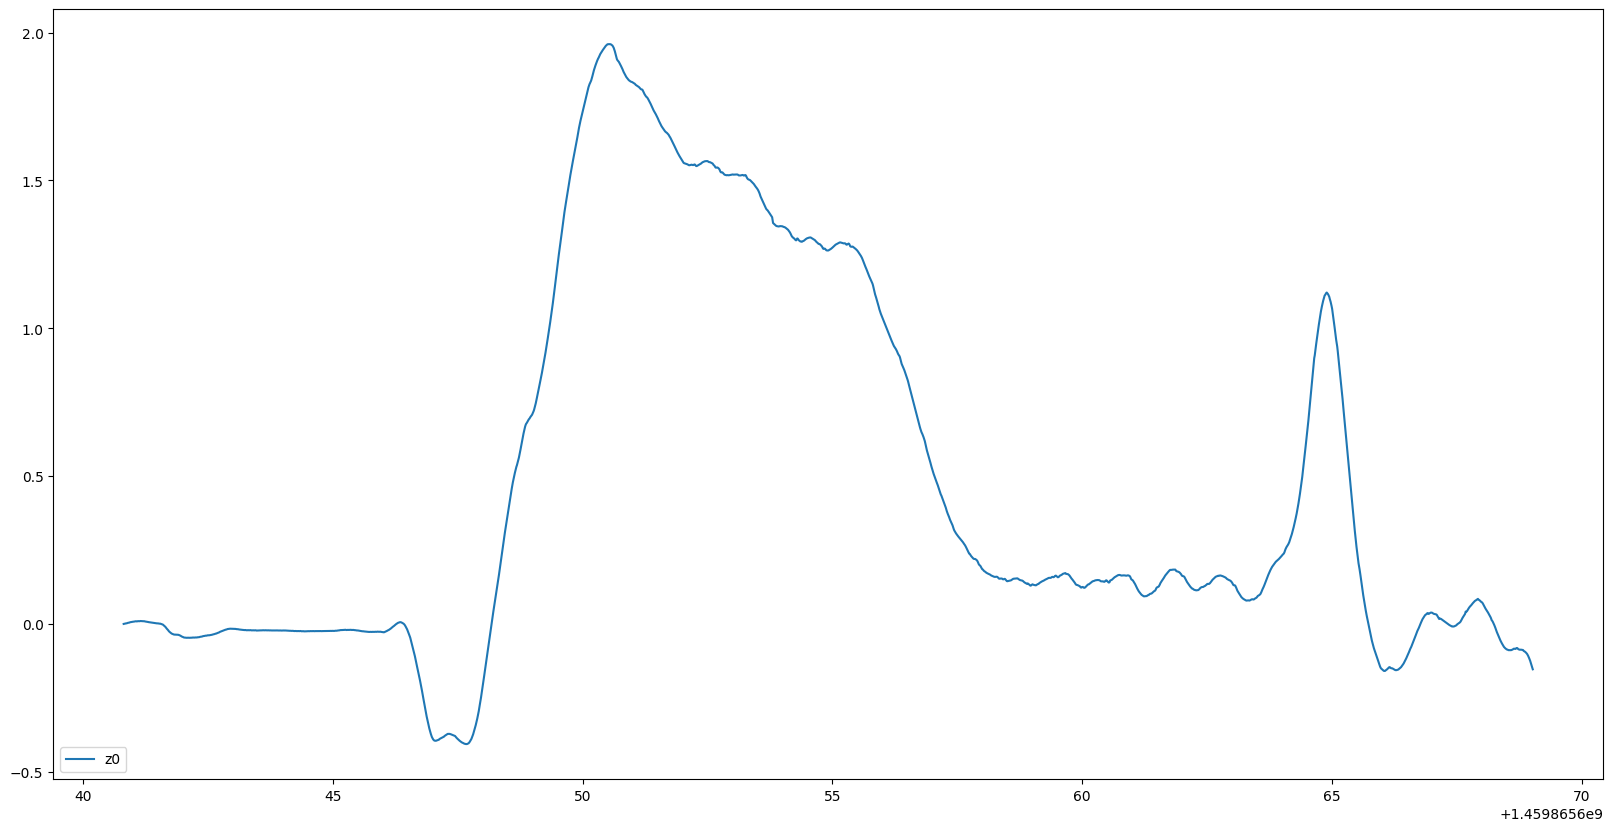

In [63]:
draw_orientation(gt_track, axis=[2])

## RMSE

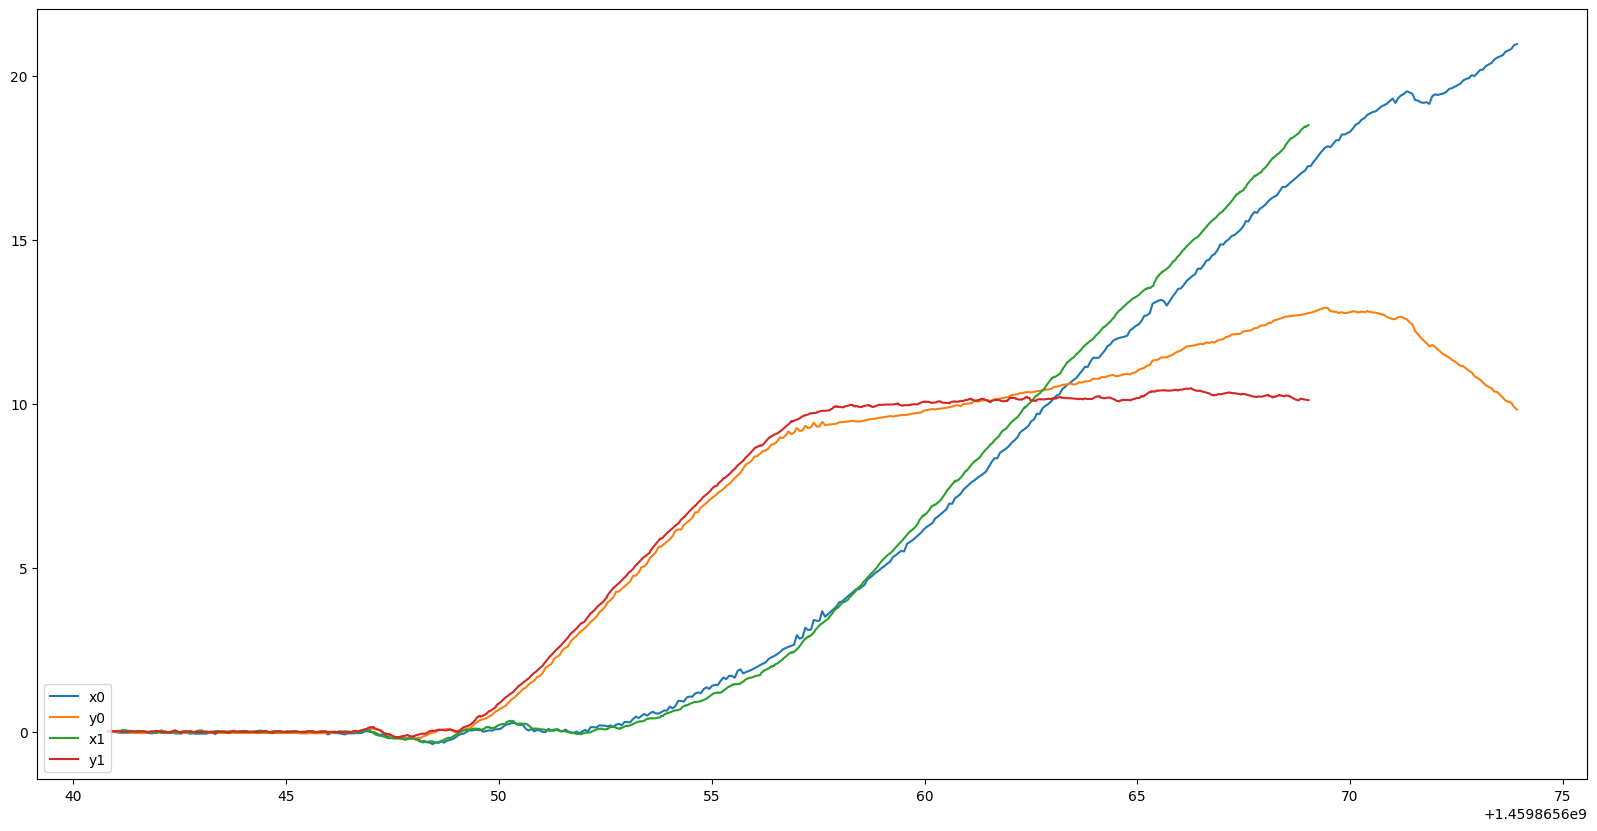

In [64]:
draw_position(track, gt_track, axis=[0, 1])

In [82]:
def rmse(gt_track, track):
    res, n = 0, 0
    gt_stamps, gt_poses = gt_track
    i, N = 0, len(gt_stamps)
    for stamp, pos in zip(track[0], track[1]):
        # since the points do not have the same time, we need to find the closest ones in time
        while i < N and stamp > gt_stamps[i]:
            i += 1
        if i >= N:
            break

        pos = pos[:3]
        gt_pos = gt_poses[i][:3]
        res += np.linalg.norm(pos - gt_pos)**2
        n += 1

    return np.sqrt(res / n)

In [83]:
rmse(gt_track, track)

0.9077624846999963